In [19]:
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import albumentations as A

In [5]:
# Function to load and preprocess images from a given folder path
def load_images(folder_path, target_size=(64, 64)):
    images = []
    image_labels = []
    
    # Define a set of transformations using the Albumentations library
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Resize(*target_size),
    ])

    # Mapping labels from folder names to numeric values: 'O' is mapped to 0, 'R' is mapped to 1
    label_mapping = {'O': 0, 'R': 1}

    # Check if the folder exists, raise an error if not
    if not os.path.exists(folder_path):
        raise ValueError(f"Folder not found: {folder_path}")
    
    print(f"Loading and preprocessing images from: {folder_path}")

    # Loop through each folder in the specified directory
    for class_folder in os.listdir(folder_path):
        # Process only if the folder name matches the labels in the label mapping ('O' or 'R')
        if class_folder in label_mapping:  
            class_path = os.path.join(folder_path, class_folder)
            print(f"Processing class: {class_folder}")

            # Loop through each image file in the current class folder
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                
                # Open the image and convert it to RGB format
                image = Image.open(image_path).convert('RGB')
                image_array = np.array(image)

                # Apply the transformations to the image
                augmented = transform(image=image_array)
                image_array = augmented['image']

                # Flatten the image array and append to the images list
                images.append(image_array.flatten())
                image_labels.append(label_mapping[class_folder])

    print(f"Finished loading and preprocessing {len(images)} images from {folder_path}")  

    # Return the images and labels as NumPy arrays
    return np.array(images), np.array(image_labels)

# Load and preprocess training images and labels
print("Loading training data...")
train_images, train_labels = load_images('DATASET/TRAIN')
print("Training data loaded successfully.")

print("Loading testing data...")
test_images, test_labels = load_images('DATASET/TEST')
print("Testing data loaded successfully.")

Loading training data...
Loading and preprocessing images from: DATASET/TRAIN
Processing class: O
Processing class: R
Finished loading and preprocessing 22564 images from DATASET/TRAIN
Training data loaded successfully.
Loading testing data...
Loading and preprocessing images from: DATASET/TEST
Processing class: O
Processing class: R
Finished loading and preprocessing 2513 images from DATASET/TEST
Testing data loaded successfully.


In [6]:
# Scale the images using MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it
print("Scaling training images...")
train_images_scaled = scaler.fit_transform(train_images)
print("Training images scaled successfully.")

# Use the already fitted scaler to transform the test data
print("Scaling testing images...")
test_images_scaled = scaler.transform(test_images)
print("Testing images scaled successfully.")

from sklearn.ensemble import IsolationForest

# Initialize IsolationForest model with 1% contamination (outliers)
iso_forest = IsolationForest(contamination=0.01, random_state=42)

# Fit the IsolationForest model on the scaled training data
print("Fitting Isolation Forest on the training data for outlier detection...")
iso_forest.fit(train_images_scaled)
print("Isolation Forest fitted successfully.")

# Predict outliers in the training data
predictions = iso_forest.predict(train_images_scaled)

# Count the number of outliers (labeled as -1 in predictions)
outliers = np.sum(predictions == -1)
print(f'Number of outliers detected: {outliers}')

# Create a mask for the normal data points (labeled as 1 in predictions)
mask = predictions == 1

# Filter out the outliers from the training data
clean_train_images_scaled = train_images_scaled[mask]
clean_train_labels = train_labels[mask]

print(f"Cleaned training data contains {clean_train_images_scaled.shape[0]} samples after removing outliers.")

Scaling training images...
Training images scaled successfully.
Scaling testing images...
Testing images scaled successfully.
Fitting Isolation Forest on the training data for outlier detection...
Isolation Forest fitted successfully.
Number of outliers detected: 226
Cleaned training data contains 22338 samples after removing outliers.


In [10]:
# Initialize variables to track the best parameters and accuracy

best_k = 1
best_n_components = 1
best_accuracy = 0

# Loop over different numbers of PCA components (from 2 to 50 in steps of 10)
for n_components in range(2, 51, 10):
    
    # Apply PCA with the current number of components
    pca = PCA(n_components=n_components, random_state=42)
    
    # Fit PCA on the scaled training data and transform it
    train_images_pca = pca.fit_transform(clean_train_images_scaled)
    
    # Transform the scaled test data using the same PCA
    test_images_pca = pca.transform(test_images_scaled)
    
    # Loop over different values of K for KNN (from 1 to 50)
    for k in range(1, 51):
        
        # Initialize and train the KNN model with the current K value
        knn = KNeighborsClassifier(n_neighbors=k, weights="distance")
        knn.fit(train_images_pca, clean_train_labels)
        
        # Make predictions on the test data using the trained KNN model
        test_predictions = knn.predict(test_images_pca)
        
        # Calculate the accuracy of the predictions
        accuracy = accuracy_score(test_labels, test_predictions)
        
        # If this accuracy is better than the best so far, update the best parameters
        if accuracy > best_accuracy:
            best_k = k
            best_n_components = n_components
            best_accuracy = accuracy
        
        # Print the current PCA components, K value, and the accuracy
        print(f"PCA Components = {n_components}, K = {k}, Accuracy: {accuracy * 100:.2f}%")

# After loop, print the best PCA components, best K value, and the best accuracy achieved
print(f"\nBest PCA Components = {best_n_components}, Best K = {best_k} with Accuracy: {best_accuracy * 100:.2f}%")

PCA Components = 2, K = 1, Accuracy: 65.74%
PCA Components = 2, K = 2, Accuracy: 65.74%
PCA Components = 2, K = 3, Accuracy: 68.40%
PCA Components = 2, K = 4, Accuracy: 69.68%
PCA Components = 2, K = 5, Accuracy: 70.19%
PCA Components = 2, K = 6, Accuracy: 70.79%
PCA Components = 2, K = 7, Accuracy: 71.15%
PCA Components = 2, K = 8, Accuracy: 72.42%
PCA Components = 2, K = 9, Accuracy: 72.86%
PCA Components = 2, K = 10, Accuracy: 73.82%
PCA Components = 2, K = 11, Accuracy: 73.82%
PCA Components = 2, K = 12, Accuracy: 74.21%
PCA Components = 2, K = 13, Accuracy: 74.02%
PCA Components = 2, K = 14, Accuracy: 74.21%
PCA Components = 2, K = 15, Accuracy: 74.61%
PCA Components = 2, K = 16, Accuracy: 74.73%
PCA Components = 2, K = 17, Accuracy: 74.93%
PCA Components = 2, K = 18, Accuracy: 75.13%
PCA Components = 2, K = 19, Accuracy: 75.29%
PCA Components = 2, K = 20, Accuracy: 75.09%
PCA Components = 2, K = 21, Accuracy: 75.01%
PCA Components = 2, K = 22, Accuracy: 75.49%
PCA Components = 2,

Processing k values: 100%|██████████| 1/1 [01:01<00:00, 61.92s/it]


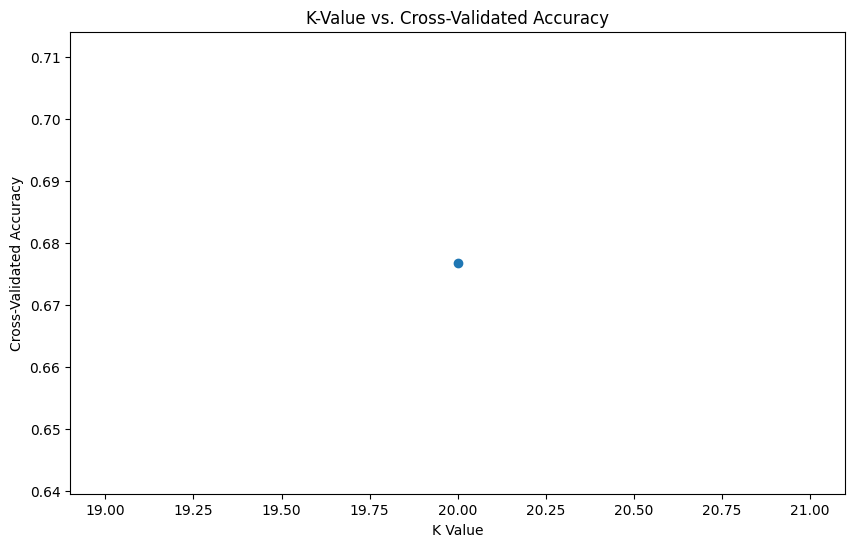

In [12]:
# optimal K value for KNN classification by evaluating each K value's performance using cross-validation
# Range of K values to test (from 1 to 40)
k_range = range(1, 41)
k_score = []

# Loop through each K value and calculate the cross-validated accuracy
# tqdm is used to show a progress bar for the K value processing
for k in tqdm(k_range, desc='Processing k values'):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    scores = cross_val_score(knn, clean_train_images_scaled, clean_train_labels, cv=5, scoring='accuracy', n_jobs=-1)
    k_score.append(scores.mean())

# Plot the K values against the cross-validated accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_score, marker='o')
plt.title('K-Value vs. Cross-Validated Accuracy')
plt.xlabel('K Value')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

Applying PCA to reduce dimensions...
PCA applied: data reduced to 16 components.


Processing k values: 100%|██████████| 30/30 [00:14<00:00,  2.08it/s]


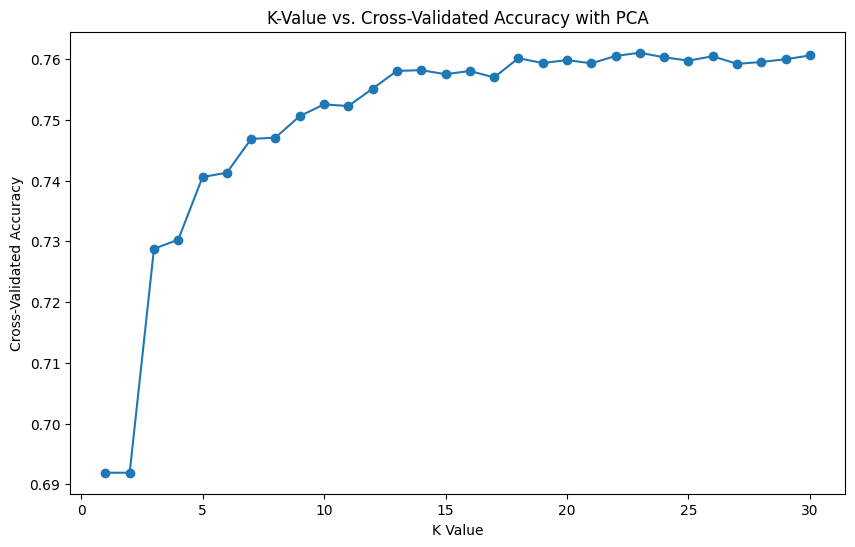

In [13]:
# PCA (Principal Component Analysis) to reduce the dimensionality of the training data

pca = PCA(n_components=16, random_state=42)

# Fit PCA on the scaled training data and transform it
print("Applying PCA to reduce dimensions...")
train_images_pca = pca.fit_transform(clean_train_images_scaled)
print(f"PCA applied: data reduced to 16 components.")

k_range = range(1, 31)
k_score = []

# Loop through each K value and calculate the cross-validated accuracy
# tqdm is used to show a progress bar for the K value processing
for k in tqdm(k_range, desc='Processing k values'):
    knn = KNeighborsClassifier(n_neighbors=k, weights="distance")
    scores = cross_val_score(knn, train_images_pca, clean_train_labels, cv=5, scoring='accuracy', n_jobs=-1)
    k_score.append(scores.mean())

# Plot the K values against the cross-validated accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_score, marker='o')
plt.title('K-Value vs. Cross-Validated Accuracy with PCA')
plt.xlabel('K Value')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [16]:
# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=44, weights="distance")

# Train the KNN model on the PCA-transformed training data
print("Training KNN model with K=44...")
knn.fit(train_images_pca, clean_train_labels)
print("KNN model trained successfully.")

# Transform the test images using the previously fitted PCA
print("Applying PCA to the test images...")
test_images_pca = pca.transform(test_images_scaled)
print("Test images transformed successfully.")

# Make predictions on the PCA-transformed test data using the trained KNN model
print("Making predictions on the test data...")
test_predictions = knn.predict(test_images_pca)
print("Predictions completed.")

# Calculate the accuracy of the model on the test set
accuracy = accuracy_score(test_labels, test_predictions)

print("KNN Results")
print("Classification Report:\n", classification_report(test_labels, test_predictions))
print(f'Accuracy: {accuracy * 100:.2f}%')

Training KNN model with K=44...
KNN model trained successfully.
Applying PCA to the test images...
Test images transformed successfully.
Making predictions on the test data...
Predictions completed.
KNN Results
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87      1401
           1       0.89      0.75      0.81      1112

    accuracy                           0.85      2513
   macro avg       0.86      0.84      0.84      2513
weighted avg       0.85      0.85      0.84      2513

Accuracy: 84.64%


In [20]:
# Train the Logistic Regression model
log_reg = LogisticRegression()

# Train the Logistic Regression model on the PCA-transformed training data
print("Training Logistic Regression model...")
log_reg.fit(train_images_pca, clean_train_labels)
print("Logistic Regression model trained successfully.")

# Make predictions on the PCA-transformed test data
print("Making predictions on the test data with Logistic Regression...")
y_pred_log_reg = log_reg.predict(test_images_pca)
print("Predictions completed.")

# Calculate the accuracy of the model on the test set
accuracy = accuracy_score(test_labels, y_pred_log_reg)

print("Logistic Regression Results")
print("Classification Report:\n", classification_report(test_labels, y_pred_log_reg))
print(f'Accuracy: {accuracy * 100:.2f}%')

Training Logistic Regression model...
Logistic Regression model trained successfully.
Making predictions on the test data with Logistic Regression...
Predictions completed.
Logistic Regression Results
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      1401
           1       0.91      0.77      0.84      1112

    accuracy                           0.87      2513
   macro avg       0.88      0.86      0.86      2513
weighted avg       0.87      0.87      0.87      2513

Accuracy: 86.71%
